<a href="https://colab.research.google.com/github/MicheleGiambelli/Deep-Learning-Project/blob/Matteo/Crypto_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This project was carried out by: Tommaso Biganzoli, Michele Giambelli, Matteo Delle Cave*

# **Deep Learning Project**
### **Predicting Solana Cryptocurrency Prices Using LSTM-Based Linear Regression**

*First we import all the necessary libraries*

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import files

import math
import scipy.stats as stats
from scipy.stats import shapiro, pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load and prepare data

### Introduction

In this project, we aim to predict the price of Solana (SOL), a popular cryptocurrency, using a Long Short-Term Memory (LSTM) model within the framework of linear regression. To achieve this, we gathered data for both Solana and Bitcoin (BTC) using the Python [**yfinance**](https://pypi.org/project/yfinance/) library .

1. **Bitcoin (BTC) Data**: Bitcoin's historical price data was used to calculate the beta coefficient, which measures Solana's sensitivity to and correlation with broader market movements. The beta coefficient is a key metric in financial analysis, providing insights into how Solana's price dynamics are influenced by changes in Bitcoin, which serves as a benchmark for the cryptocurrency market.

2. **Solana (SOL) Data**: Solana’s historical price data, also retrieved using `yfinance`, served as the foundation for training the LSTM model. This dataset provided the necessary time-series information to forecast future price movements accurately.

The `yfinance` library is a powerful Python tool that allows seamless access to financial data from Yahoo Finance. It enables users to retrieve historical data, including prices, volumes, and other market indicators, for a wide range of financial instruments, such as stocks, cryptocurrencies, and indices. By leveraging `yfinance`, we streamlined the data acquisition process, ensuring comprehensive and reliable datasets for our analysis.

This integrated approach combines statistical insights derived from Bitcoin's beta with the predictive capabilities of LSTM, forming a robust methodology for forecasting Solana's future prices based on historical trends and market behavior.

In [28]:
ticker = "SOL-USD"
btc_ticker = "BTC-USD"

solana_data = yf.download(ticker, start="2020-04-10")
btc_data = yf.download(btc_ticker, start="2020-04-10")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
# We want to create a df with both btc and sol
solana_data = solana_data.rename(columns={"Adj Close": "SOL_Adj_Close"})
btc_data = btc_data.rename(columns={"Adj Close": "BTC_Adj_Close"})

# Data merging
# Instead of selecting individual columns, use the renamed dataframes directly
df = pd.concat([solana_data, btc_data], axis=1)
df = df.dropna()

# Calculate daily returns
df["SOL_Return"] = df["SOL_Adj_Close"].pct_change()
df["BTC_Return"] = df["BTC_Adj_Close"].pct_change()

# Function to calculate Beta
def rolling_beta(df, window):
    cov = df["SOL_Return"].rolling(window).cov(df["BTC_Return"])
    var = df["BTC_Return"].rolling(window).var()
    return cov / var

# Define n before using it in rolling_beta
n = 20  # For example, a 20-day rolling window for beta calculation

# Add Beta
df["Beta"] = rolling_beta(df, n)
df = df.dropna()


This code calculates Bollinger Bands using a 20-day window (n = 20) to align with typical financial analysis standards for short-term trends. The bands help detect overbought (above upper band) or oversold (below lower band) conditions, aiding in market timing and price movement analysis.

In [30]:
n = 20  # Period for Bollinger Bands and Beta
k = 2  # Standard deviations for Bollinger Bands

# Calculate Bollinger Bands
df["SMA"] = df["SOL_Adj_Close"].rolling(window=n).mean()
df["StdDev"] = df["SOL_Adj_Close"].rolling(window=n).std()
df["Upper_Band"] = df["SMA"] + k * df["StdDev"]
df["Lower_Band"] = df["SMA"] - k * df["StdDev"]
df = df.dropna()


The `rolling_sharpe_ratio` function calculates the Sharpe Ratio over a rolling window, helping to assess risk-adjusted returns for Solana.  

- `window`: The rolling window size for calculating mean and standard deviation of returns.  
- `risk_free_rate`: The risk-free rate used to adjust returns.  

The function outputs the Sharpe Ratio, which evaluates the return per unit of risk over the specified window.

In [31]:
def rolling_sharpe_ratio(df, window, risk_free_rate):
    rolling_mean = df["SOL_Return"].rolling(window).mean()
    rolling_std = df["SOL_Return"].rolling(window).std()
    return (rolling_mean - risk_free_rate) / rolling_std
risk_free_rate = 0.01
# Add the  Sharpe Ratio to the df
df["Sharpe_Ratio"] = rolling_sharpe_ratio(df, n, risk_free_rate)
df = df.dropna()


In [32]:
df.drop(df.columns[[6,7,8,9,10,11,13]], axis=1, inplace=True) # dropping BTC columns
df.head()

Price,SOL_Adj_Close,Close,High,Low,Open,Volume,SOL_Return,Beta,SMA,StdDev,Upper_Band,Lower_Band,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,,,
Date,,,,,,,,,,,,,
2020-06-07,0.616578,0.616578,0.624444,0.593398,0.622443,716785,-0.009423,0.427358,0.595371,0.027581,0.650533,0.540209,-0.201951
2020-06-08,0.668313,0.668313,0.679001,0.613310,0.615078,1440234,0.083907,0.428930,0.597564,0.031483,0.660529,0.534599,-0.085599
2020-06-09,0.658002,0.658002,0.668088,0.627242,0.667784,988327,-0.015428,0.346123,0.601506,0.033900,0.669306,0.533706,-0.038440
2020-06-10,0.644867,0.644867,0.670043,0.633404,0.658038,1096203,-0.019962,0.524364,0.603304,0.035240,0.673784,0.532823,-0.103663
2020-06-11,0.573742,0.573742,0.650535,0.570082,0.644888,1122221,-0.110294,0.739265,0.600047,0.034787,0.669620,0.530474,-0.229623


In [33]:
df.tail()

Price,SOL_Adj_Close,Close,High,Low,Open,Volume,SOL_Return,Beta,SMA,StdDev,Upper_Band,Lower_Band,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,,,
Date,,,,,,,,,,,,,
2024-12-03,234.200317,234.200317,239.272522,216.473022,225.768570,8404095315,0.037404,1.134428,236.977356,12.988001,262.953359,211.001353,-0.115827
2024-12-04,229.119293,229.119293,240.719589,225.254913,234.200317,6569129896,-0.021695,1.066410,237.972367,11.416749,260.805866,215.138868,-0.109308
2024-12-05,233.998703,233.998703,244.680954,223.460541,229.119385,8820663279,0.021296,0.955565,238.767557,10.474358,259.716273,217.818841,-0.136633
2024-12-06,237.051071,237.051071,246.418655,231.425964,236.541473,6726557034,0.013044,0.889403,239.827669,9.002143,257.831954,221.823383,-0.108802
2024-12-07,242.634201,242.634201,243.099777,234.717743,237.076462,3986616320,0.023552,1.024791,240.080602,9.006600,258.093802,222.067403,-0.237401


# **DEA**

The first step in our Data Exploratory Analysis (DEA) focuses on understanding the historical price behavior and statistical properties of Solana (SOL). Below is a breakdown of the process:

Plotting the Historical Time Series:
We visualize Solana's historical closing prices starting from July 2020. This step provides an overview of price trends, volatility, and significant market movements over time.

Checking Normality of the Distribution:
To examine the statistical characteristics of Solana's closing prices:

1. QQ Plot: We use a Quantile-Quantile plot to visually inspect if the data follows a normal distribution.
2. [Shapiro-Wilk test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html): A formal statistical test is performed to validate the normality assumption of the data.
Analyzing the Correlation Matrix:
To detect potential multicollinearity issues among the variables, we calculate the correlation matrix. This analysis helps identify highly correlated features, which may impact model performance in later stages.

Investigating Linearity:
Finally, we assess the linearity of the data by examining relationships between variables. This step ensures that the assumptions required for linear regression are met and highlights the suitability of our dataset for predictive modeling.

Through this structured approach, we aim to build a comprehensive understanding of Solana's data and prepare it for subsequent analysis and modeling.

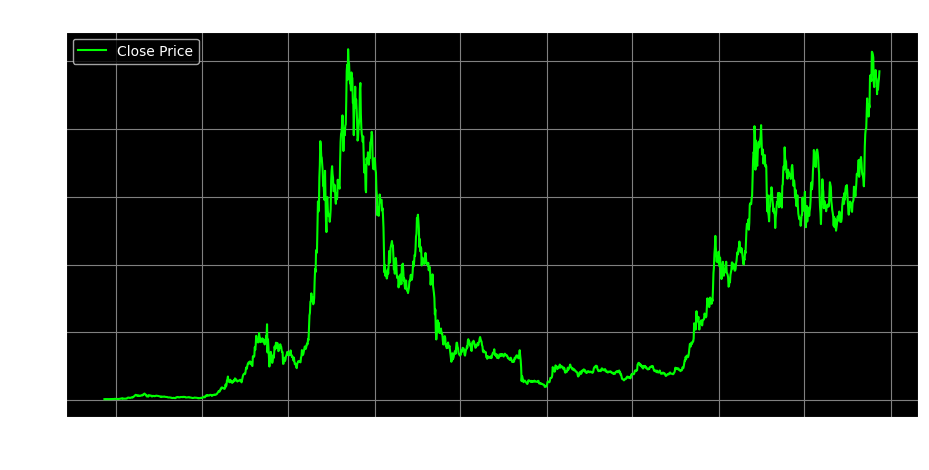

In [34]:
# Plot of historical price trend
plt.figure(figsize=(11, 5))
plt.style.use('dark_background')
plt.plot(df.index, df[('Close', 'SOL-USD')], label='Close Price', color='lime')
plt.title('Solana Time Serie (Close Price)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(color='gray')
plt.show()

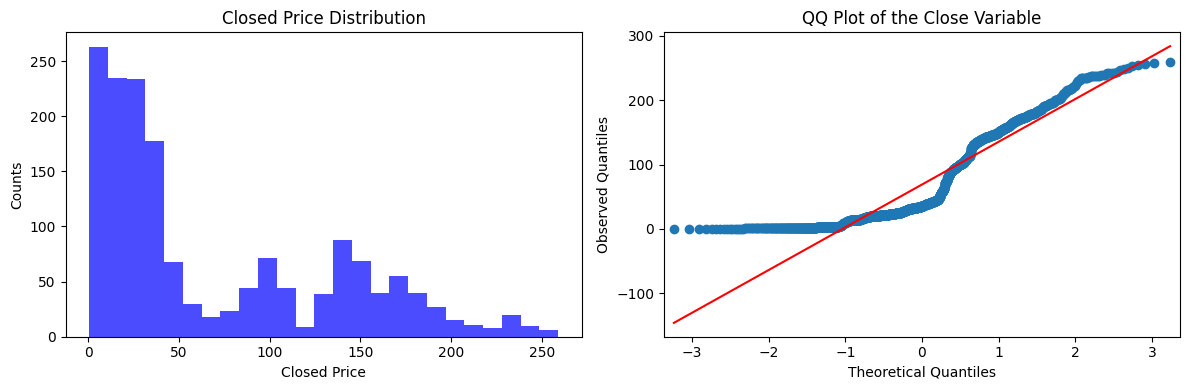

In [35]:
plt.style.use('default')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histogram plot
axs[0].hist(df[('Close', 'SOL-USD')], bins=25, color='blue', alpha=0.7)
axs[0].set_xlabel('Closed Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Closed Price Distribution')

# QQ plot
sm.qqplot(df[('Close', 'SOL-USD')], line='s', ax=axs[1])
axs[1].set_title('QQ Plot of the Close Variable')
axs[1].set_xlabel('Theoretical Quantiles')
axs[1].set_ylabel('Observed Quantiles')

plt.tight_layout()
plt.show()

The histogram on the left shows the distribution of the Close Price for Solana, which is highly skewed to the right (positively skewed). This is evident from the long tail towards higher values, indicating that the data does not follow a normal distribution. The QQ plot on the right confirms this by showing significant deviations from the straight line, particularly in the tails.

Suggested Distributions:
1. **Lognormal Distribution**: Given the positive skewness and strictly positive nature of the data, a lognormal distribution is a strong candidate. It is often used for modeling variables that grow multiplicatively, such as prices or incomes.
2. **Gamma Distribution**: Another suitable option for positively skewed data, the Gamma distribution offers more flexibility, particularly for datasets with peaks or variations.

Scaling Recommendations:
To preprocess the data effectively:

1. **[MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html)**: Suitable for rescaling the data into a defined range (e.g., [0, 1]) and preserving the shape of the original distribution. Ideal for positively skewed data.
2. **[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)**: A better choice when there are outliers, as it scales the data using the interquartile range (IQR) and is less sensitive to extreme values.
3. *Avoid [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html): Since the data is not normally distributed, using a standard scaler (which assumes Gaussian distribution) would not be appropriate.*

In [36]:
# Perform the Shapiro-Wilk test on the 'Close' variable
stat, p_value = shapiro(df['Close'])

print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")
if p_value > 0.05:
    print("The data distribution is likely normal (fail to reject H0).")
else:
    print("The data distribution is not normal (reject H0).")

Shapiro-Wilk Test Statistic: 0.8543
P-Value: 0.0000
The data distribution is not normal (reject H0).


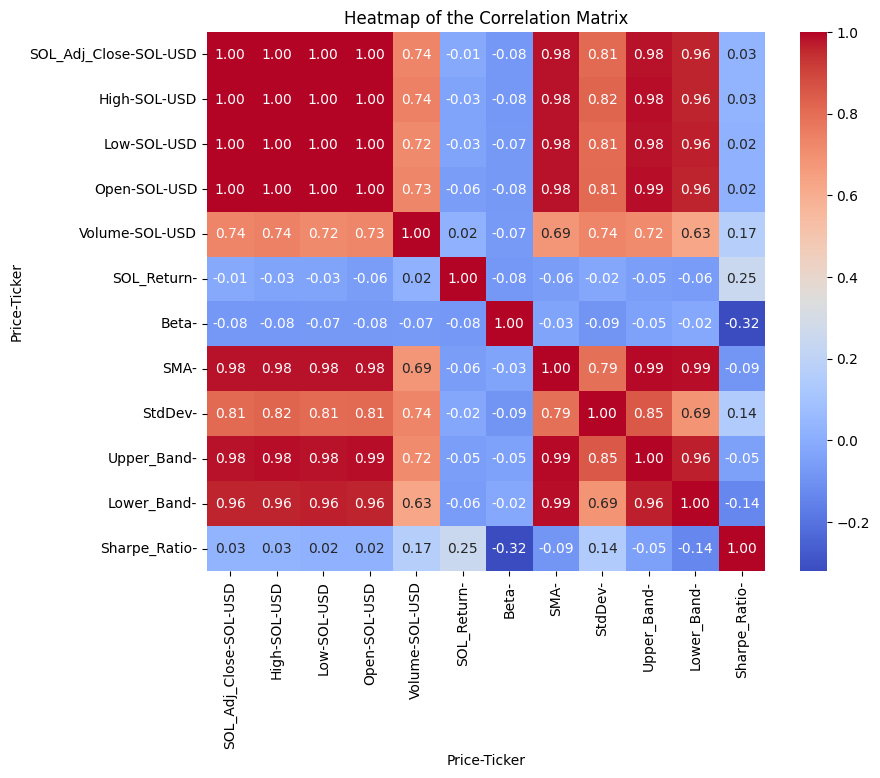

Variance Inflation Factor (VIF):
                    Variable          VIF
7                    (SMA, )          inf
8                 (StdDev, )          inf
9             (Upper_Band, )          inf
10            (Lower_Band, )          inf
1            (High, SOL-USD)  1745.384101
0   (SOL_Adj_Close, SOL-USD)  1172.783189
3            (Open, SOL-USD)  1031.761848
2             (Low, SOL-USD)   946.750954
4          (Volume, SOL-USD)     4.478637
11          (Sharpe_Ratio, )     1.830546
5             (SOL_Return, )     1.739065
6                   (Beta, )     1.163767


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [37]:
# Removing NaN values for a clean analysis
df_sol_clean = df.dropna()

# Handling MultiIndex: remove the target variable by specifying both levels
target_var = ('Close', 'SOL-USD')  # Exact name of the variable in the MultiIndex
independent_vars = [col for col in df_sol_clean.columns if col != target_var]

# Correlation matrix
correlation_matrix = df_sol_clean[independent_vars].corr()

# Visualization of the correlation matrix
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of the Correlation Matrix")
plt.show()

# Calculating VIF (Variance Inflation Factor)
X = df_sol_clean[independent_vars]
X_with_const = sm.add_constant(X)  # Add a constant for VIF calculation

vif_data = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i + 1) for i in range(X.shape[1])]
}).sort_values(by="VIF", ascending=False)

# Display VIF results
print("Variance Inflation Factor (VIF):")
print(vif_data)


### Correlation Matrix and VIF Analysis

1. **High Collinearity Among SMA, Upper_Band, and Lower_Band**:
   - The correlation matrix shows that **SMA**, **Upper_Band**, and **Lower_Band** are almost perfectly correlated (correlation ≈ 1).  
   - The VIF values for these variables are infinite (`inf`), confirming severe multicollinearity.  
   - Including all three would introduce redundancy in the model. Since **SMA** represents the central trend, it is sufficient to retain SMA and exclude **Upper_Band** and **Lower_Band**.

2. **Highly Correlated Price Features**:
   - The variables **High**, **Low**, **Open**, and **SOL_Adj_Close** (adjusted close) are nearly perfectly correlated with each other (correlation ≈ 1).  
   - The VIF values for these variables are excessively high (> 1000), indicating multicollinearity issues.  
   - Retaining all these variables is unnecessary, as they provide redundant information. Since **SOL_Adj_Close** is the dependent variable, features like **Open** and others closely tied to it should be removed to avoid duplication of information.

3. **Independent Variables with Acceptable Multicollinearity**:
   - Features such as **Beta**, **Sharpe_Ratio**, and **SOL_Return** have low VIF values (< 5), indicating that they are relatively independent and provide unique information to the model. These variables should be retained.

By addressing these issues, we ensure that the regression model is not adversely affected by multicollinearity, leading to better model interpretability and stability.

### Scatterplots

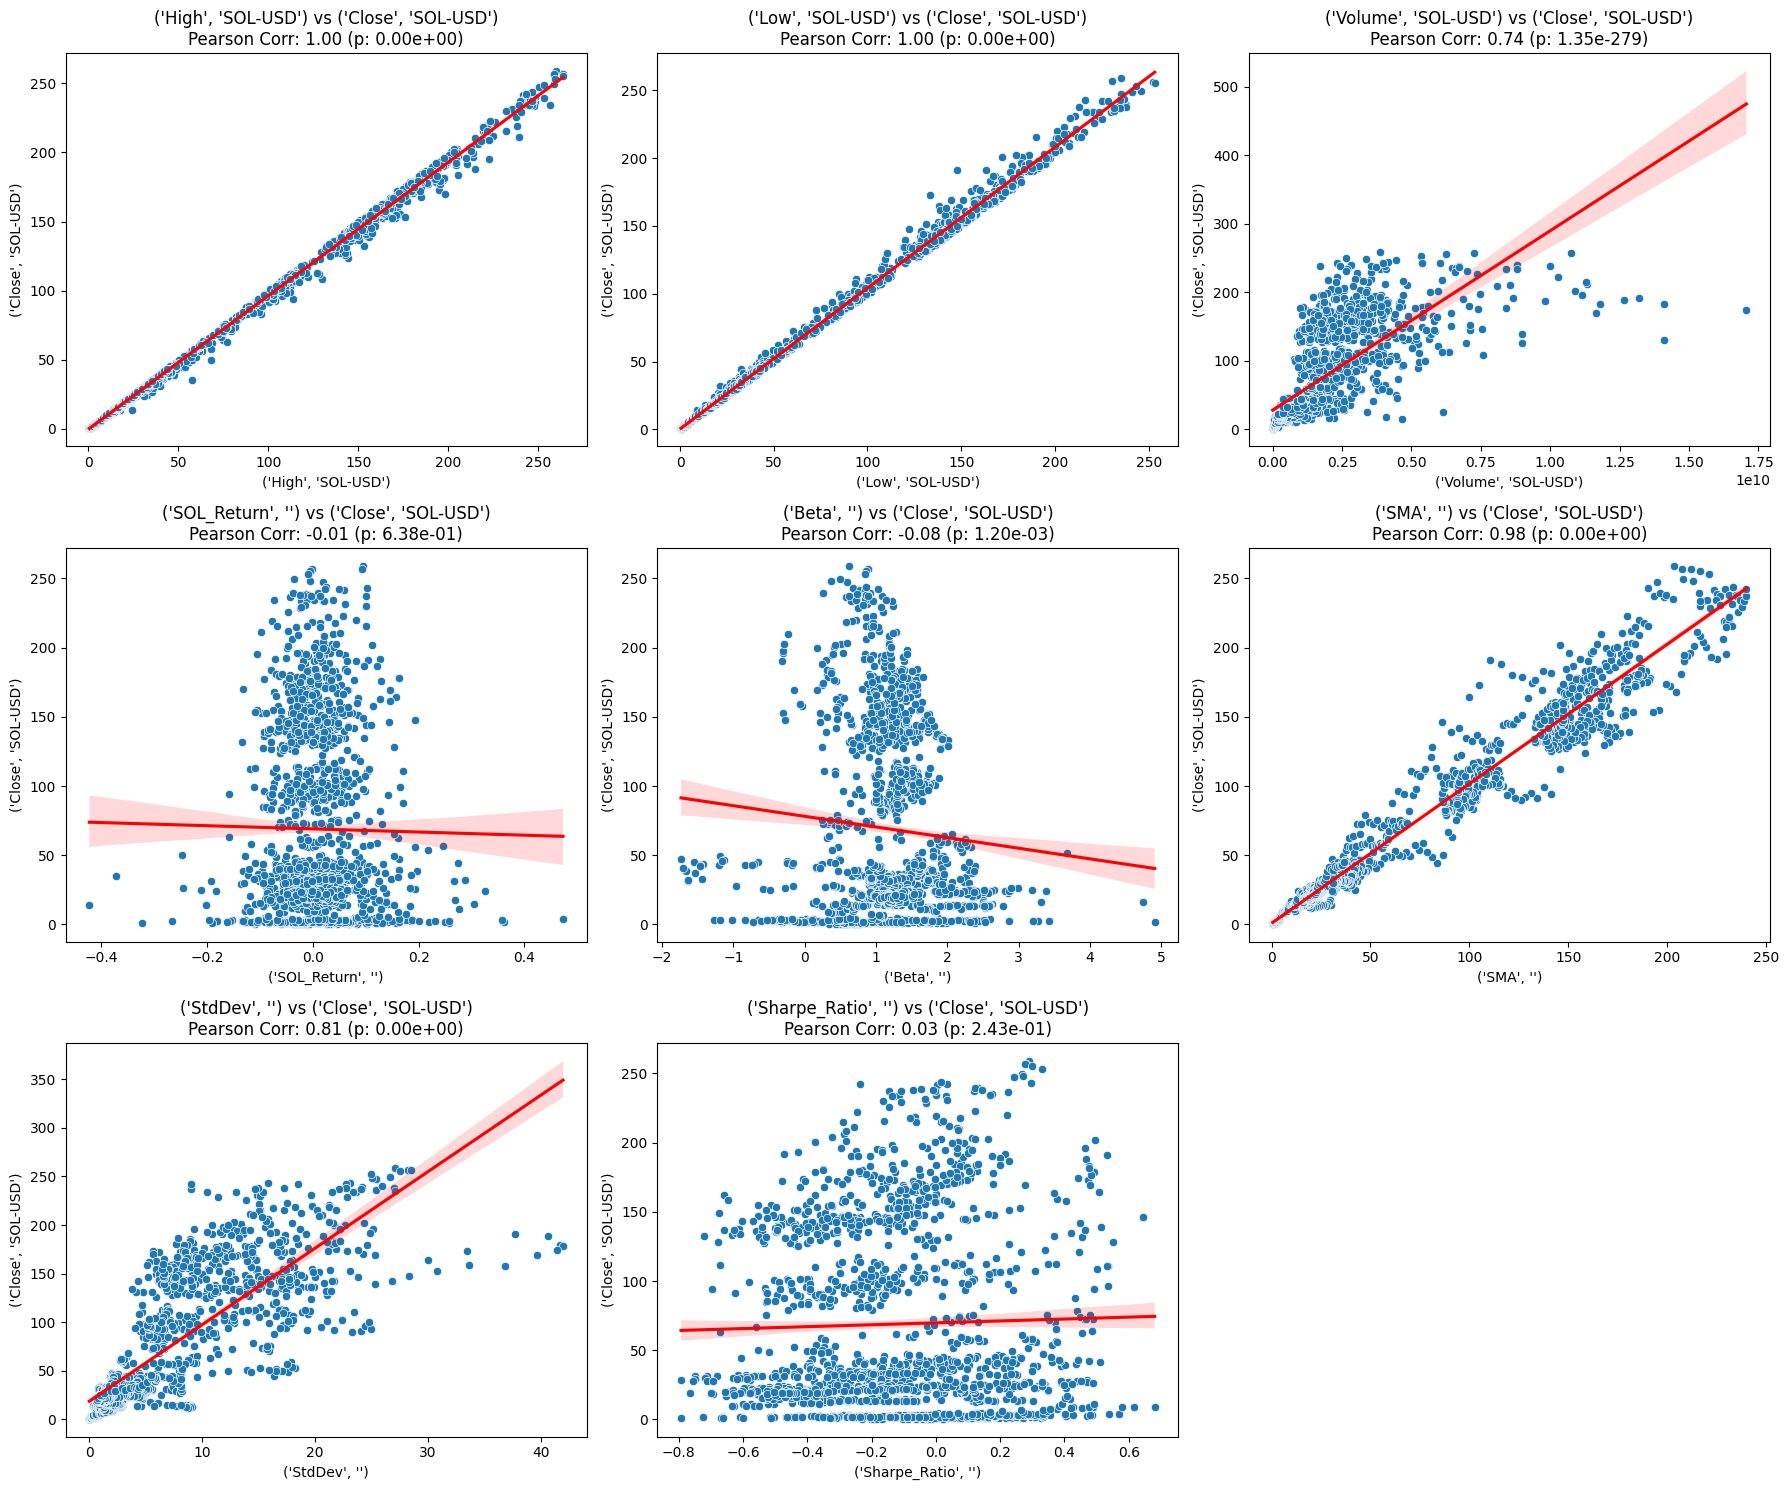

In [38]:
# Dependent variable
dependent_var = ('Close', 'SOL-USD')

# List of independent variables (with MultiIndex)
independent_vars = [
    ('High', 'SOL-USD'),
    ('Low', 'SOL-USD'),
    ('Volume', 'SOL-USD'),
    ('SOL_Return', ''),
    ('Beta', ''),
    ('SMA', ''),
    ('StdDev', ''),
    ('Sharpe_Ratio', '')
]

# Filter available variables
available_vars = [var for var in independent_vars if var in df.columns]

# Remove rows with NaN values in the variables of interest
df_filtered = df.dropna(subset=[dependent_var] + available_vars)

# Grid configuration for the plots
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(available_vars) // n_cols)  # Number of required rows (ceil)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Scatter plots and linearity analysis
for i, var in enumerate(available_vars):
    ax = axes[i]
    sns.scatterplot(x=df_filtered[var], y=df_filtered[dependent_var], ax=ax)
    sns.regplot(x=df_filtered[var], y=df_filtered[dependent_var], scatter=False, color='red', ax=ax)

    # Calculate Pearson correlation coefficient
    corr, p_value = pearsonr(df_filtered[var], df_filtered[dependent_var])
    ax.set_title(f"{var} vs {dependent_var}\nPearson Corr: {corr:.2f} (p: {p_value:.2e})")
    ax.set_xlabel(var)
    ax.set_ylabel(dependent_var)

# Hide empty axes in the grid
for j in range(len(available_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


The inclusion of scatterplots in DEA serves multiple important purposes:

1. Visualizing Relationships: Scatterplots provide an intuitive, visual representation of the relationships between each independent variable and the dependent variable (Close Price of Solana). This is vital for understanding how each feature contributes to the target variable.

2. Assessing Linearity: For regression models, linearity between variables is a key assumption. Scatterplots help evaluate whether the relationship is approximately linear or if non-linear trends exist, guiding potential transformations or alternative modeling approaches.

In [39]:
# Modify the DataFrame with the new covariates

# Remove the specified columns from the DataFrame
columns_to_drop = [('SOL_Adj_Close', 'SOL-USD'), ('Open', 'SOL-USD'), ('Upper_Band', ''), ('Lower_Band', '')]

# Create the new DataFrame
df = df.drop(columns=columns_to_drop)
df.head()


Price,Close,High,Low,Volume,SOL_Return,Beta,SMA,StdDev,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,
Date,,,,,,,,,
2020-06-07,0.616578,0.624444,0.593398,716785,-0.009423,0.427358,0.595371,0.027581,-0.201951
2020-06-08,0.668313,0.679001,0.613310,1440234,0.083907,0.428930,0.597564,0.031483,-0.085599
2020-06-09,0.658002,0.668088,0.627242,988327,-0.015428,0.346123,0.601506,0.033900,-0.038440
2020-06-10,0.644867,0.670043,0.633404,1096203,-0.019962,0.524364,0.603304,0.035240,-0.103663
2020-06-11,0.573742,0.650535,0.570082,1122221,-0.110294,0.739265,0.600047,0.034787,-0.229623


**<h1>Pytorch Dataset</h1>**

### Description of the Code below

This code prepares the dataset for training, validation, and testing. Here's an explanation of the main components:

Data Normalization:

The dataset (df) is normalized using MinMax scaler.fit_transform to ensure that all features are on the same scale. This step is crucial for machine learning models, particularly LSTMs, to converge efficiently.
Sequence Creation:

A sequence length of 5 is defined, meaning each input sequence contains 5 consecutive timesteps of normalized data.
The code iteratively constructs the input features (X_sequences) and the target variable (y_sequences) for each time window. This setup aligns with how LSTMs process sequential data.
Tensor Conversion:

The sequences are converted into PyTorch tensors (X_tensor and y_tensor) for compatibility with PyTorch models.
The target tensor y_tensor is reshaped using unsqueeze(-1) to match the expected dimensionality.
Dataset Splitting:

The dataset is split into training (70%), validation (20%), and testing (10%) subsets, while maintaining the temporal order of the data:

The first 70% of the observations are used for training.

The next 20% are reserved for validation.

The final 10% are used for testing.

This ensures that the model learns from past observations and is validated/tested on future unseen data, mimicking a real-world forecasting scenario.

DataLoader Creation:

A load_array function is defined to create PyTorch DataLoader objects for efficient batch processing.
batch_size is set to 32, meaning the model will process data in mini-batches of 32 samples, which balances memory usage and training speed.
Batch Inspection:

The code retrieves a single batch from the training DataLoader and prints its shape for verification:
batch_X contains the input sequences (torch.Size([32, 5, num_features])).
batch_y contains the corresponding target values (torch.Size([32, 1])).


In [42]:
data = df.values
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)

# Save the number of features (columns)
num_features = data.shape[1]

# Create sequences
sequence_length = 30
X_sequences = []
y_sequences = []
y_sequences5 = []
y_sequences7 = []

n = len(data_norm)

for i in range(n - sequence_length-7):
    X_seq = data_norm[i:i+sequence_length]
    y_seq = data_norm[i + sequence_length][0]
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)
    y_seq5 = data_norm[i + sequence_length+5][0]
    y_seq7 = data_norm[i + sequence_length+5][0]
    y_sequences5.append(y_seq5)
    y_sequences7.append(y_seq7)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)
y_sequences5 = np.array(y_sequences5)
y_sequences7 = np.array(y_sequences7)


X_tensor = torch.tensor(X_sequences, dtype=torch.float32)
y_tensor = torch.tensor(y_sequences, dtype=torch.float32).unsqueeze(-1)
y_tensor5 = torch.tensor(y_sequences5, dtype=torch.float32).unsqueeze(-1)
y_tensor7 = torch.tensor(y_sequences7, dtype=torch.float32).unsqueeze(-1)

In [43]:
# Splitting into training, validation, and test sets
n = len(X_sequences)
train_split = int(n * 0.7)  # First 70% of observations for training
val_split = int(n * 0.9)    # Next 20% of observations for validation
test_split = n              # Last 10% of observations for testing

train_dataset = (X_tensor[:train_split], y_tensor[:train_split])
val_dataset = (X_tensor[train_split:val_split], y_tensor[train_split:val_split])
test_dataset = (X_tensor[val_split:test_split], y_tensor[val_split:test_split])

train_dataset5 = (X_tensor[:train_split], y_tensor5[:train_split])
val_dataset5 = (X_tensor[train_split:val_split], y_tensor5[train_split:val_split])
test_dataset5 = (X_tensor[val_split:test_split], y_tensor5[val_split:test_split])

train_dataset7 = (X_tensor[:train_split], y_tensor7[:train_split])
val_dataset7 = (X_tensor[train_split:val_split], y_tensor7[train_split:val_split])
test_dataset7 = (X_tensor[val_split:test_split], y_tensor7[val_split:test_split])


In [44]:
# Define a function for loading data with unpacking
def load_array(data_arrays, batch_size, is_train=False): # False because we want to read the data historically
    """Construct a PyTorch DataLoader."""
    dataset = TensorDataset(*data_arrays)  # Unpacking the tensors
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

# Create the DataLoader
batch_size = 32
train_loader = load_array(train_dataset, batch_size, is_train=True)
valid_loader = load_array(val_dataset, batch_size)
test_loader = load_array(test_dataset, batch_size)

train_loader5 = load_array(train_dataset5, batch_size, is_train=True)
valid_loader5 = load_array(val_dataset5, batch_size)
test_loader5 = load_array(test_dataset5, batch_size)

train_loader7 = load_array(train_dataset7, batch_size, is_train=True)
valid_loader7 = load_array(val_dataset7, batch_size)
test_loader7 = load_array(test_dataset7, batch_size)


In [45]:
batch_X, batch_y = next(iter(train_loader))
print(batch_X.shape)
print(batch_y.shape)


torch.Size([32, 30, 9])
torch.Size([32, 1])


# **Benchmark Model**

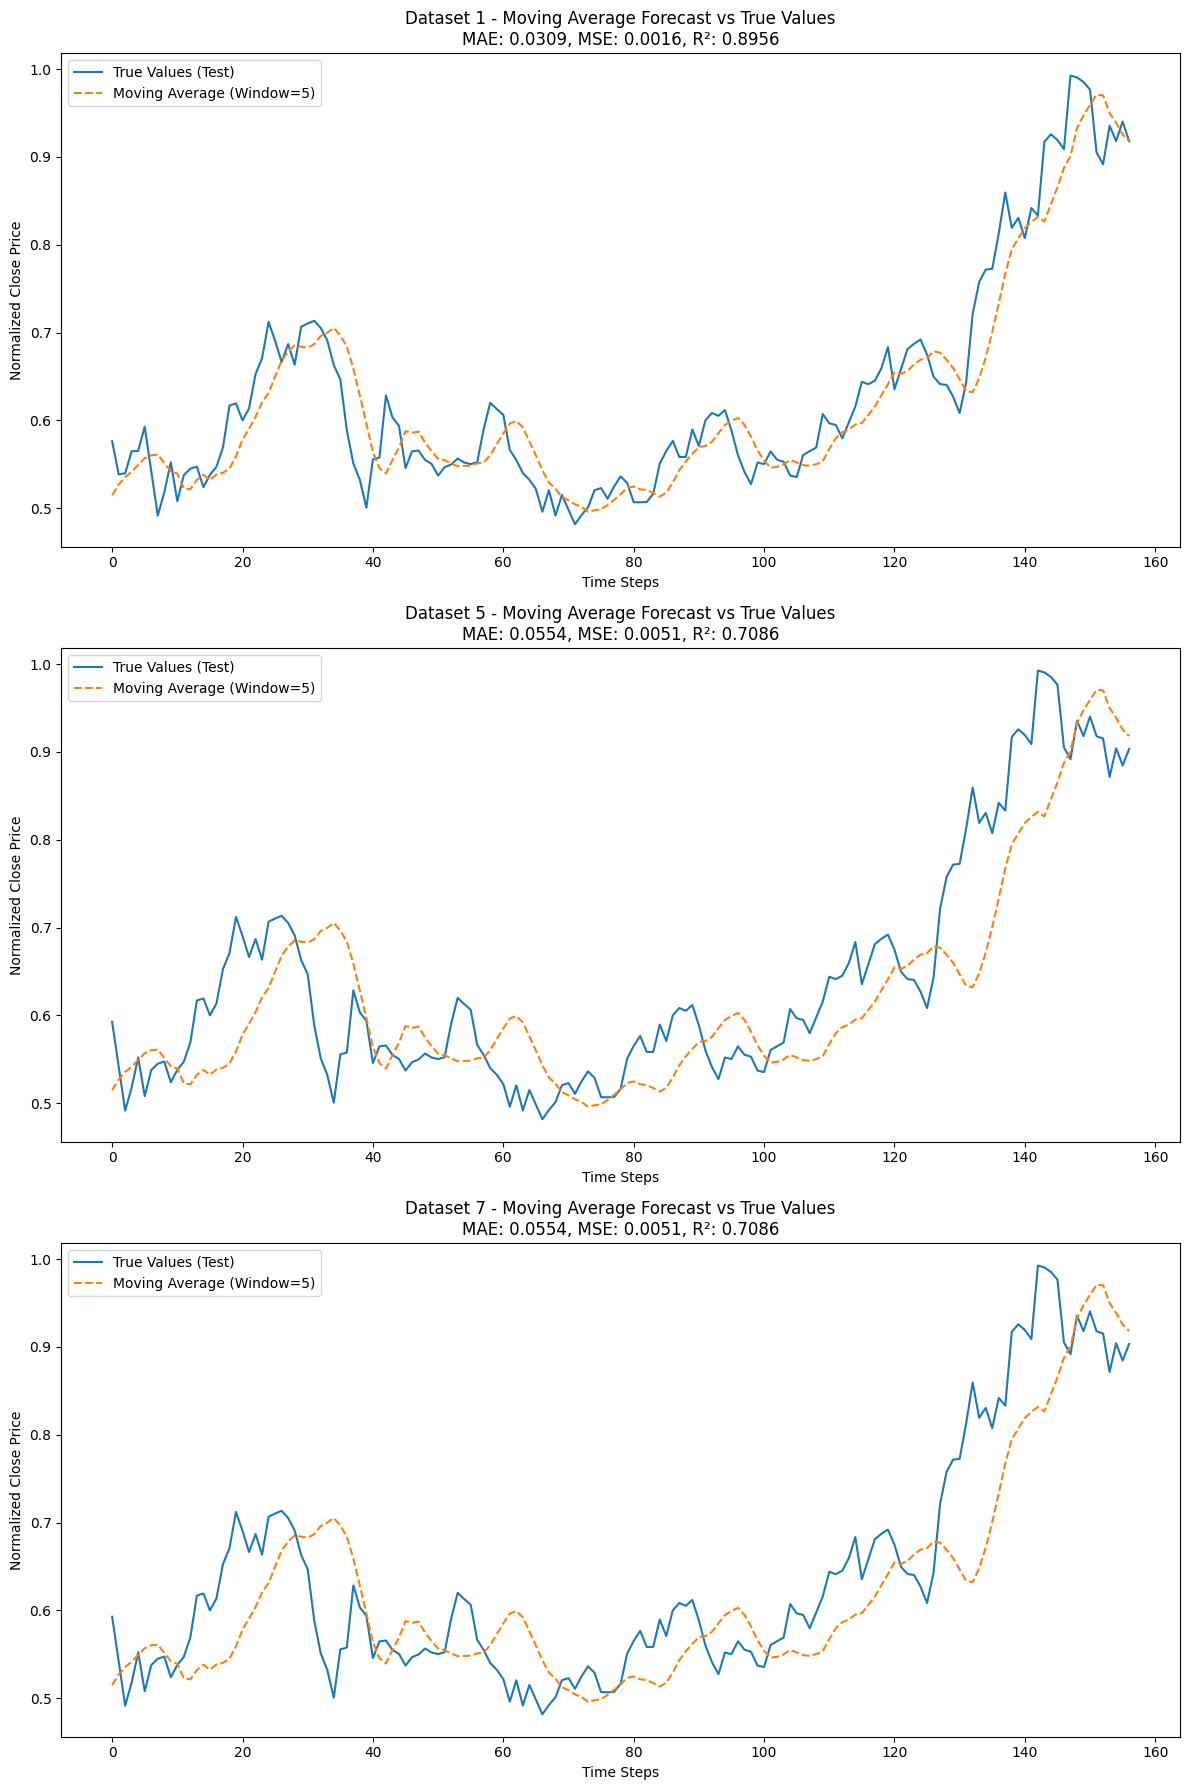

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List of datasets
datasets = [(test_dataset, "Dataset 1"), (test_dataset5, "Dataset 5"), (test_dataset7, "Dataset 7")]

# Window size for the moving average
window_size = 5

# Function to calculate the moving average
def moving_average_forecast(data, window_size):
    """
    Calculates the moving average for the given data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot configuration
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # Create a figure with 3 rows for subplots

for i, (dataset, title) in enumerate(datasets):
    # Extract test data and true values
    test_data = dataset[0].numpy()[:, -1, 0]  # Extract the last column of sequences (normalized Close)
    true_values = dataset[1].numpy()[:, 0]   # Actual values (normalized Close)

    # Calculate the moving average
    y_pred = moving_average_forecast(test_data, window_size)

    # Align true values with predictions
    y_true = true_values[window_size-1:]

    # Calculate metrics
    mae_ma = mean_absolute_error(y_true, y_pred)
    mse_ma = mean_squared_error(y_true, y_pred)
    r2_ma = r2_score(y_true, y_pred)

    # Plot the results
    ax = axes[i]
    ax.plot(range(len(y_true)), y_true, label="True Values (Test)", linestyle="-")
    ax.plot(range(len(y_pred)), y_pred, label=f"Moving Average (Window={window_size})", linestyle="--")
    ax.set_title(f"{title} - Moving Average Forecast vs True Values\nMAE: {mae_ma:.4f}, MSE: {mse_ma:.4f}, R²: {r2_ma:.4f}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Normalized Close Price")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# **LSTM**

### LSTM Model

The Long Short-Term Memory (LSTM) model implemented in this project is designed to predict time-series data, in our case Solana's cryptocurrency price. The model is structured with two stacked LSTM layers, a dropout layer to mitigate overfitting, and a fully connected layer for the final output.

#### Model Architecture:
1. **Input Layer**: Processes the time-series data, using past observations of multiple features as input.
2. **First LSTM Layer**: Learns the temporal patterns in the data and outputs a sequence of hidden states.
3. **Dropout Layer**: Reduces overfitting by randomly deactivating neurons during training.
4. **Second LSTM Layer**: Refines the temporal features extracted by the first LSTM layer.
5. **Fully Connected Layer**: Outputs the final prediction based on the learned features.

#### Advantages of Using LSTM in Time-Series Analysis:
1. **Learning Temporal Dependencies**: LSTMs are designed to capture patterns and relationships over time, making them ideal for sequential data like cryptocurrency prices.
2. **Handling Non-Stationary Data**: LSTMs are robust to trends and fluctuations in time-series data, which are common in financial datasets.

#### Comments on Hyperparameters:
- **`input_size = 9`**: Corresponds to the number of features in the dataset. This ensures the model processes all relevant variables.
- **`hidden_size = 100`**: Determines the number of neurons in each LSTM layer, controlling the model's capacity to learn complex patterns.
- **`output_size = 1`**: Outputs a single value, the predicted Solana price.
- **`learning_rate = 0.001`**: A low learning rate allows the model to converge gradually, reducing the risk of overshooting the optimal solution.
- **`num_epochs = 200`**: The total number of training cycles, balancing model convergence and overfitting.
- **`dropout = 0.2`**: Helps prevent overfitting by deactivating 20% of neurons during training.


In [60]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.dropout = dropout

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True)
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden state and cell state for the first LSTM layer
        h0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the first LSTM layer
        out, _ = self.lstm1(x, (h0_1, c0_1))

        # Forward pass through the dropout layer
        out = self.dropout_layer(out)

        # Initial hidden state and cell state for the second LSTM layer
        h0_2 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0_2 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the second LSTM layer
        out, _ = self.lstm2(out, (h0_2, c0_2))

        # Forward pass through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out


In [61]:
# Hyperparameters
input_size = 9
hidden_size = 100
output_size = 1
learning_rate = 0.001
num_epochs = 200
dropout = 0.2

# Model initialization, loss function, and optimizer
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Check if MAE loss is more suitable
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False
best_model_state = None

**Model Training**

In [62]:
# Lists to store metrics for each dataset
results = {
    "Dataset 1": {"train_losses": [], "val_losses": [], "train_mae": [], "val_mae": [], "epochs": []},
    "Dataset 5": {"train_losses": [], "val_losses": [], "train_mae": [], "val_mae": [], "epochs": []},
    "Dataset 7": {"train_losses": [], "val_losses": [], "train_mae": [], "val_mae": [], "epochs": []}
}

datasets = [
    (train_loader, valid_loader, "Dataset 1"),
    (train_loader5, valid_loader5, "Dataset 5"),
    (train_loader7, valid_loader7, "Dataset 7")
]

for train_loader, valid_loader, dataset_name in datasets:
    print(f"\nTraining on {dataset_name}...\n")
    # Reset model, optimizer, and state variables for each dataset
    model.train()
    train_losses = []
    val_losses = []
    train_mae = []
    val_mae = []
    epochs = []

    early_stop = False
    best_loss = float("inf")
    epochs_no_improve = 0
    best_epoch = 0
    best_model_state = None

    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} with best val loss {best_loss:.4f}")
            model.load_state_dict(best_model_state)
            break

        # Training phase
        model.train()
        train_loss = 0.0
        train_actuals = []
        train_predictions = []

        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and weight update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_actuals.extend(batch_y.numpy())
            train_predictions.extend(outputs.detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Save training loss
        train_mae.append(mean_absolute_error(train_actuals, train_predictions))  # Save training MAE

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_actuals = []
        val_predictions = []

        with torch.no_grad():
            for val_X, val_y in valid_loader:
                val_outputs = model(val_X)
                loss = criterion(val_outputs, val_y)
                val_loss += loss.item()
                val_actuals.extend(val_y.numpy())
                val_predictions.extend(val_outputs.numpy())

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # Save validation loss
        val_mae.append(mean_absolute_error(val_actuals, val_predictions))  # Save validation MAE
        epochs.append(epoch + 1)  # Save epoch

        # Print metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train MAE: {train_mae[-1]:.4f}, Val MAE: {val_mae[-1]:.4f}")

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            best_epoch = epoch + 1
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= 5:
            early_stop = True




Training on Dataset 1...

Epoch [1/200], Train Loss: 0.0201, Val Loss: 0.0047, Train MAE: 0.0965, Val MAE: 0.0517
Epoch [2/200], Train Loss: 0.0019, Val Loss: 0.0017, Train MAE: 0.0298, Val MAE: 0.0305
Epoch [3/200], Train Loss: 0.0017, Val Loss: 0.0014, Train MAE: 0.0261, Val MAE: 0.0260
Epoch [4/200], Train Loss: 0.0016, Val Loss: 0.0043, Train MAE: 0.0259, Val MAE: 0.0442
Epoch [5/200], Train Loss: 0.0014, Val Loss: 0.0012, Train MAE: 0.0249, Val MAE: 0.0239
Epoch [6/200], Train Loss: 0.0014, Val Loss: 0.0011, Train MAE: 0.0235, Val MAE: 0.0253
Epoch [7/200], Train Loss: 0.0010, Val Loss: 0.0009, Train MAE: 0.0198, Val MAE: 0.0218
Epoch [8/200], Train Loss: 0.0009, Val Loss: 0.0009, Train MAE: 0.0185, Val MAE: 0.0216
Epoch [9/200], Train Loss: 0.0011, Val Loss: 0.0016, Train MAE: 0.0210, Val MAE: 0.0313
Epoch [10/200], Train Loss: 0.0010, Val Loss: 0.0010, Train MAE: 0.0201, Val MAE: 0.0215
Epoch [11/200], Train Loss: 0.0010, Val Loss: 0.0007, Train MAE: 0.0196, Val MAE: 0.0187
Epo

# Commenti da cambiare

1. Early Stopping with Optimal Weights:

State Management: At each epoch, the model’s [state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) (which contains its parameters, such as weights and biases) is saved if the validation loss improves. This ensures the ability to restore the best model weights at the epoch with the lowest validation loss.
Efficiency: The model stops training at epoch 26, reverting to the best model state from epoch 21, where the validation loss reached its minimum (0.0005335).
This approach prevents overfitting and ensures that the model uses the optimal weights at the end of training.

2. Training and Validation Metrics:

Loss (MSE): Tracks the Mean Squared Error, showing the model's progress in minimizing the difference between predictions and actual values.
MAE: Provides an interpretable measure of the average prediction error, complementing the loss for model evaluation.
3. Output Analysis:

Epoch 1: Train Loss: 0.0271, Val Loss: 0.0112, Train MAE: 0.1151, Val MAE: 0.0986. Early in training, the model shows significant room for improvement.
Epoch 10: Train Loss: 0.0009, Val Loss: 0.0008, Train MAE: 0.0174, Val MAE: 0.0191. The model converges to low error values for both datasets.
Best Epoch (21): Train Loss: 0.0007, Val Loss: 0.0005, Train MAE: 0.0162, Val MAE: 0.0156. This indicates the point of optimal generalization before validation loss begins to fluctuate.
4. Model Generalization:

The validation loss closely follows the training loss without significant divergence, suggesting no overfitting.
The consistent gap between the two losses is expected and indicates that the model generalizes well to unseen data.


In [65]:
# Save the best model
if best_model_state is not None:
    save_path = "best_model.pth"
    torch.save(best_model_state, save_path)
    print(f"Best model saved to {save_path}")

Best model saved to best_model.pth


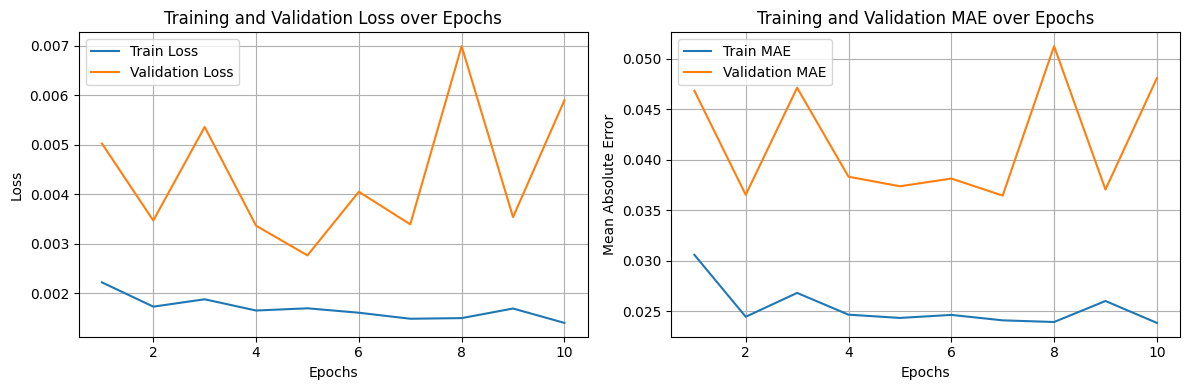

In [66]:
# Visualize the metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axs[0].plot(epochs, train_losses, label='Train Loss')
axs[0].plot(epochs, val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].legend()
axs[0].grid()

# MAE plot
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].plot(epochs, val_mae, label='Validation MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].set_title('Training and Validation MAE over Epochs')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

*Gradual Convergence:*

The training loss and validation loss decrease sharply in the initial epochs and stabilize afterward, indicating that the model is effectively learning from the data.
This behavior shows proper optimization without early anomalies or divergence, demonstrating a well-configured learning process.

*No Evidence of Overfitting:*

The validation loss closely follows the training loss, with no significant divergence throughout the epochs. This suggests that the model generalizes well and does not overfit the training data.
Toward the end, the validation loss stabilizes slightly above the training loss, which is expected since the validation set represents unseen data.

*Well-Configured Early Stopping:*

The training stopped after epoch 26, as early stopping criteria were met. The model reverted to epoch 21, where the validation loss reached its minimum (0.0005335), preventing unnecessary computations and overfitting.

*Consistency Between Training and Validation Metrics:*

Both the training and validation loss, as well as MAE, follow a similar trend with a minimal and consistent gap. This indicates that the model maintains good generalization across the datasets.
The validation MAE stabilizes below 0.02, highlighting the model's ability to predict with low average error on unseen data.
This analysis shows that the model's training process is well-configured, with effective convergence, no overfitting, and reliable early stopping.


In [67]:
# Examin test set
model.eval()
test_predictions = []
test_actuals = []

model.eval()

with torch.no_grad(): # we do not have to update the weights
    for test_X, test_y in test_loader:
        outputs = model(test_X)
        test_predictions.extend(outputs.numpy())
        test_actuals.extend(test_y.numpy())

In [68]:
def denormalization(pred, test_actuals, num_features):

  pred = np.array(pred).reshape(-1, 1)
  test_predictions_expanded = np.zeros((pred.shape[0], num_features))
  test_predictions_expanded[:, 0] = pred[:, 0]
  pred = scaler.inverse_transform(test_predictions_expanded)
  pred = pred[:, 0]

  test_actuals = np.array(test_actuals).reshape(-1, 1)
  test_actuals_expanded = np.zeros((test_actuals.shape[0], num_features))
  test_actuals_expanded[:, 0] = test_actuals[:, 0]
  test_actuals_denorm = scaler.inverse_transform(test_actuals_expanded)
  test_actuals_denorm = test_actuals_denorm[:, 0]
  return pred, test_actuals_denorm

test_predictions, test_actuals = denormalization(test_predictions, test_actuals, num_features)

The `denormalization` function restores normalized predictions and actual test values to their original scale using the scaler's inverse transformation. It reshapes the inputs, expands them to match the original feature dimensions, applies the inverse transformation, and extracts the target variable. This ensures predictions and actual values are comparable on their original scale for evaluation.

In [69]:
# Perfomance output
stop = 0
print("Predictions vs Real Values")
for i, j  in zip(test_predictions, test_actuals):
  print(f"{round(i, 2)} $      {round(j, 2)} $")
  stop += 1
  if stop == 10:
    break

Predictions vs Real Values
107.64 $      128.59 $
106.33 $      132.24 $
107.66 $      136.56 $
110.14 $      136.61 $
111.6 $      149.45 $
117.45 $      139.7 $
117.47 $      140.01 $
116.63 $      146.49 $
118.07 $      146.6 $
120.22 $      153.7 $


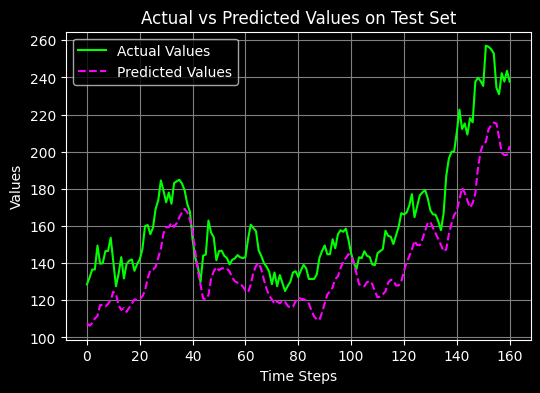

In [70]:
# Performance plot
plt.style.use('dark_background')
plt.figure(figsize=(6, 4))
plt.plot(test_actuals, label='Actual Values', color='lime')
plt.plot(test_predictions, label='Predicted Values', color='fuchsia', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(color='gray')
plt.show()

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the LSTM model on the test dataset
model.eval()  # Set the model to evaluation mode

test_actuals = []
test_predictions = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # LSTM predictions
        test_actuals.extend(batch_y.numpy().flatten())  # Collect actual values
        test_predictions.extend(outputs.numpy().flatten())  # Collect predictions

# Convert to numpy arrays for metric calculations
test_actuals = np.array(test_actuals)
test_predictions = np.array(test_predictions)

# Calculate metrics
mae_lstm = mean_absolute_error(test_actuals, test_predictions)
mse_lstm = mean_squared_error(test_actuals, test_predictions)
r2_lstm = r2_score(test_actuals, test_predictions)

print(f"Metrics for LSTM Model:")
print(f"Mean Absolute Error (MAE): {mae_lstm:.4f}")
print(f"Mean Squared Error (MSE): {mse_lstm:.4f}")
print(f"R² Score: {r2_lstm:.4f}")


Metrics for LSTM Model:
Mean Absolute Error (MAE): 0.0840
Mean Squared Error (MSE): 0.0092
R² Score: 0.4072


Il formato del tensore torch.Size([32, 12]) che ottieni con next(iter(data_loader))[0].shape è parzialmente corretto per creare una LSTM, ma manca una dimensione fondamentale: la dimensione di sequenza temporale.

Per una LSTM, il tensore di input dovrebbe avere la seguente forma:

(
batch_size
,
sequence_length
,
input_size
)
(batch_size,sequence_length,input_size)

Spesso la scelta di sequence_length viene fatta sperimentalmente:

Prova diversi valori (ad esempio, 1, 5, 7) e confronta le prestazioni del modello (ad esempio, tramite metriche come MSE o MAE).
Usa la validazione incrociata per capire quale valore produce le previsioni più accurate.
